## Todo:
- Learning with sequential stream of classes
- MIT-67 and Stanford-40 datasets for novel classes
- See when are results bad/equal/better? See which classes they correspond to. 

In [2]:
%matplotlib inline

# General imports
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import pegasos
import time
import pickle
from collections import defaultdict

# Core imports
from svm import SVM_Triplet
import pickle_utils
import cifar_utils

'''
Paths, params and hyper-params
'''
CIFAR_TRAIN = '/media/red/capstone/data/cifar-100/cifar-100-python/train'
CIFAR_CUSTOM = '/media/red/capstone/data/cifar-100/cifar-custom.pkl'    # Custom version of the dataset

## Feature extraction phase
We split the 100 classes in the CIFAR dataset into the following 4 subsets:
- **training** : classes 0-39 are used for training the classification network, which would eventually be used to extract 1024-dim features.
- **base** : classes 40-59 are the collection of base classes. The random 10 classes will be selected from this pool.
- **simulation** : classes 60-79 would be used for simulating the triplets. The novel class would be selected from this pool.
- **test** : classes 80-99 would be used for testing our regression network. (Similar to simulation)

In the following cells, we will work on the classification network. The output of the penultimate layer would be used as features for training the SVMs.

Raw CIFAR-100 data has 500x3072 data for each class (500 images). However, we need to store them as 3D tensors of shape (32,32,3). The **create_custom_dataset()** function does that. (And also splits it into the 4 subclasses mentioned above)

In [3]:
'''
Load custom CIFAR data. 
'''
cifar_raw = pickle_utils.load(CIFAR_TRAIN)
custom_dataset = cifar_utils.create_custom_dataset(cifar_raw)

['can', 'bowl', 'aquarium_fish', 'chair', 'crab', 'bridge', 'camel', 'house', 'elephant', 'beaver']


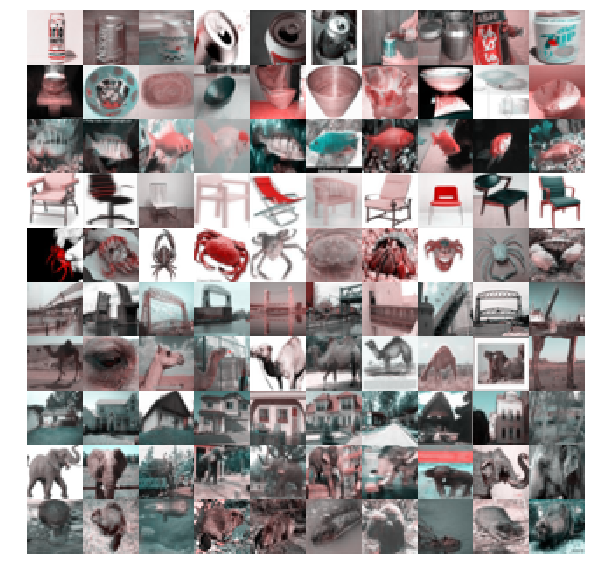

In [4]:
'''
Visualize dataset
'''
import matplotlib.gridspec as gridspec
num_rows = 10
num_cols = 10

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0, hspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
random_class_ids = np.random.permutation(range(40))[:num_rows]   # Training classes (0-39)
random_class_names = [cifar_utils.CIFAR100_LABELS_LIST[i] for i in random_class_ids] 
print(random_class_names)
for i in range(num_rows):
    for j, im in enumerate(custom_dataset['training'][random_class_ids[i]][:num_cols]):
        ax[i*num_rows+j].imshow(im)
        ax[i*num_rows+j].axis('off')
        ax[i*num_rows+j].set_aspect('auto')
plt.show()

## Training our classifier network

We will now use the 40 classes labeled as **training** from our custom dataset to train the classifier network. We will employ a simple network since the input images are only of size (32, 32, 3). 

- Conv (3x3x32)-> Conv (3x3x32)-> MaxPool -> ReLU
- Conv (3x3x64)-> Conv(3x3x64)-> MaxPool -> ReLU
- FC(1024)-> Dropout(0.1)
- FC(1024)-> Dropout(0.1)
- softmax(40)

In [ ]:
model = Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, 3, activation='relu', name='conv2_1'))
model.add(Conv2D(64, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten(name='flatten'))
model.add(Dense(1024, activation='relu', name='dense_1'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', name='dense_2'))
model.add(Dropout(0.1))
model.add(Dense(40, name='dense_3'))
model.add(Activation('softmax', name='softmax'))

optimizer = keras.optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Prepare data for training
X, Y = [], []
for label in custom_dataset['training'].keys():
    for item in custom_dataset['training'][label]:
        X.append(item)
        Y.append(label)

model.fit(np.array(X), Y, epochs=100, batch_size=32, shuffle=True)
model.save('classifier_40_100.h5')

In [ ]:
# I had some issues with using the dropout layer during prediction. Some keras bug. 
# So had to rewrite the model without dropout
pmodel = Sequential()

pmodel.add(Conv2D(32, 3, activation='relu', input_shape=(32,32,3)))
pmodel.add(Conv2D(32, 3, activation='relu', name='conv1_2'))
pmodel.add(MaxPooling2D((2, 2), strides=(2, 2)))

pmodel.add(Conv2D(64, 3, activation='relu', name='conv2_1'))
pmodel.add(Conv2D(64, 3, activation='relu', name='conv2_2'))
pmodel.add(MaxPooling2D((2, 2), strides=(2, 2)))

pmodel.add(Flatten(name='flatten'))
pmodel.add(Dense(1024, activation='relu', name='dense_1'))
pmodel.add(Dense(1024, activation='relu', name='dense_2'))
pmodel.add(Dense(40, name='dense_3'))
pmodel.add(Activation('softmax', name='softmax'))

pmodel.load_weights('classifier_40_100.h5')
get_feature_vector = K.function([pmodel.layers[0].input],
                                  [pmodel.layers[8].output])

In [ ]:
feature_vectors = {'base': {} , 'simulation': {}, 'test': {}}

for dataset in custom_dataset.keys():
    if dataset != 'training':
        print dataset + ' .....'
        for label in custom_dataset[dataset].keys():
            inp = np.array(custom_dataset[dataset][label])
            feature_vectors[dataset][label] = get_feature_vector([inp])[0]
cPickle.dump(feature_vectors, open('feature_vectors', "wb" ))

In [ ]:
def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, equal_features=False):
    
    # First 400 images will be used for training. Other 100 for testing
    TRAIN_SPLIT = 400
    
    pos_features = feature_vectors[pos_class]    # 500 x 1024 
    neg_features = []
    for neg_class in neg_classes:
        neg_features.extend(feature_vectors[neg_class])
    
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    if is_train:
        return pos_features[:TRAIN_SPLIT], np.array(neg_features[:TRAIN_SPLIT])
    else:
        return pos_features[TRAIN_SPLIT:], np.array(neg_features[TRAIN_SPLIT:])

# Modify feature_vectors structure
feature_vectors = unpickle('feature_vectors')
x = {}
for d in feature_vectors.keys():
    for label in feature_vectors[d].keys():
        x[label] = feature_vectors[d][label]
feature_vectors = x  

In [ ]:
# Simulate triplet generation
triplets = unpickle('triplets.pkl')
# triplets = []
triplet_count = len(triplets)
print triplet_count

def compute_accuracy(weight_vector, pos_features, neg_features):
    classifier = pegasos.PegasosSVMClassifier()
    classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
    classifier.weight_vector.weights = weight_vector

    # Concat data and pass to SVM
    result = classifier.predict(np.vstack((pos_features, neg_features)))
    ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    return np.average(np.equal(ground_truth, result))

def get_svm_weights(x_train, y_train):
    svm = pegasos.PegasosSVMClassifier()
    svm.fit(x_train, y_train)
    weight_vector = svm.weight_vector.weights
    return weight_vector


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y

def compute_X1(pos_class, base_classes, feature_vectors):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector

def compute_X2(pos_class, base_classes, feature_vectors):
    pos_features, neg_features = prepare_features(pos_class, base_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
    
def compute_Y(pos_class, new_class, base_classes, feature_vectors):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, new_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors)
    x_train, y_train = get_x_y(pos_features, neg_features)
    weight_vector = get_svm_weights(x_train, y_train)
    return weight_vector
 
# # Generation of SVM triplets
while triplet_count < 100000:
    t_start = time.time()
    base_classes = np.random.permutation(range(40,60))[:10]
    
    X1s = {}
    for pos_class in base_classes:
        X1s[pos_class] = compute_X1(pos_class, base_classes, feature_vectors)
    
    X2s = {}
    for new_class in range(60,80):
        X2s[new_class] = compute_X2(new_class, base_classes, feature_vectors)
        
#     print 'Precomputation of X1 and X2 .. ', time.time() - t_start
    
    # The following code generates 200 triplets - 20C10 x 20C1
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in range(60, 80):
            X2 = X2s[new_class]
            Y = compute_Y(pos_class, new_class, base_classes, feature_vectors)
            triplets.append(SVM_Triplet(X1, X2, Y, base_classes, pos_class, new_class))
            triplet_count += 1
    
    # Snapshot after every 200 triplets
    with open('triplets.pkl', 'wb') as f:
        print 'Dumping start...'
        cPickle.dump(triplets, f)
        
    print triplet_count, time.time() - t_start
    

In [ ]:
# Create a baseline
# SVM weights are not updated and new classes are added one by one
base_classes = np.random.permutation(range(40,60))[:10]
pos_class = random.choice(base_classes)
neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
X1 = compute_X1(pos_class, base_classes, feature_vectors)

pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=False)
acc = [compute_accuracy(X1, pos_features_test, neg_features_test)]

# neg_classes = []
for new_class in range(60, 100):
    neg_classes = np.append(neg_classes, new_class)
    pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=False)
    acc.append(compute_accuracy(X1, pos_features_test, neg_features_test))
    
plt.plot(range(0, 41), acc)
plt.ylabel('Base class accuracy (Randomly chosen)')
plt.xlabel('New classes added')
plt.show()

## Training the regressor network

In [ ]:
triplets = unpickle('triplets.pkl')

In [ ]:
inp = Input(shape=(2048,))
x = Dense(2048, name='dense_1')(inp)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_1')(x)
x = Dense(2048, name='dense_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_2')(x)
x = Dense(1024, name='dense_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1, name='lrelu_3')(x)
x = Dense(1024, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.RMSprop(lr=0.001)

model.compile(loss='cosine_proximity', optimizer=optimizer, metrics=['accuracy'])

# Prepare data for training
X_train, Y_train = [], []
for triplet in triplets:
    ### NORMALIZE X1, X2 and Y here!!!
#     X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
#     X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
#     Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
    
    X_train.append(np.hstack((triplet.X1, triplet.X2)))
    Y_train.append(triplet.Y-triplet.X1)


model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=32, shuffle=True, verbose=1)
time.sleep(0.1)
model.save('e100_rms_cosine_100k.h5')



In [ ]:
# Compare our model with the baseline
model = load_model('e100_rms_cosine_100k.h5')
acc, our_acc, true_acc = [], [], []
base_classes = np.random.permutation(range(40,60))[:10]
pos_class = random.choice(base_classes)
X1 = compute_X1(pos_class, base_classes, feature_vectors)

neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, False) 
acc.append(compute_accuracy(X1, pos_features_test, neg_features_test))
our_acc.append(acc[0])

our_X1 = X1
# neg_classes = []
for new_class in range(80, 100):
    neg_classes = [new_class]
#     neg_classes.append(new_class)
    pos_features_test, neg_features_test = prepare_features(pos_class, neg_classes, feature_vectors, is_train=False, equal_features=True)
    acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
    acc.append(acc1)
        
    # Test out our incremental hypothesis
#     our_X1 = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    X2 = compute_X2(new_class, base_classes, feature_vectors)
#     X2 = X2 / np.linalg.norm(X2, axis=0, keepdims=True)
    X = np.hstack((our_X1, X2))
    X = np.reshape(X, (1, 2048))
    Y_hat = model.predict(X)
    Y = our_X1 + Y_hat.reshape((1024))
#     our_X1 = Y.reshape((1024))
#     Y = Y * np.linalg.norm(X1, axis=0, keepdims=True)
    acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
    our_acc.append(acc2)
    
    
    print new_class, acc1, acc2
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(0, len(acc)), acc, 'b', label='No SVM update')
ax.plot(range(0, len(our_acc)), our_acc, 'g', label='Incremental SVM update')
plt.ylabel('Base class accuracy (Randomly chosen base class)')
plt.xlabel('ID of new class added')
ax.legend(loc=3)
plt.title('Comparision of accuracies when adding a new class (10 + 1)')
plt.show()